# Setup 🏗️


In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from random import randrange




In [2]:
viscos = 1/5200

# load RANS data created by rans.m (which can be downloaded)
# load DNS data
DNS_mean  = np.genfromtxt("LM_Channel_5200_mean_prof.dat",comments="%").transpose()
y_DNS     = DNS_mean[0]
yplus_DNS = DNS_mean[1]
u_DNS     = DNS_mean[2]
dudy_DNS  = np.gradient(u_DNS,y_DNS)

DNS_stress = np.genfromtxt("LM_Channel_5200_vel_fluc_prof.dat",comments="%").transpose()

uu_DNS = DNS_stress[2]
vv_DNS = DNS_stress[3]
ww_DNS = DNS_stress[4]
uv_DNS = DNS_stress[5]
uw_DNS = DNS_stress[6]
vw_DNS = DNS_stress[7]
k_DNS  = 0.5*(uu_DNS+vv_DNS+ww_DNS)

DNS_RSTE = np.genfromtxt("LM_Channel_5200_RSTE_k_prof.dat",comments="%")

eps_DNS = DNS_RSTE[:,7]/viscos # it is scaled with ustar**4/viscos

# fix wall
eps_DNS[0]=eps_DNS[1]

# load data from k-omega RANS
data  = np.loadtxt('y_u_k_om_uv_5200-RANS-code.txt').transpose()
y_rans     = data[0]
u_rans     = data[1]
k_rans     = data[2]
om_rans    = data[3]
diss1_rans = 0.09*k_rans*om_rans
ustar = (viscos*u_rans[0]/y_rans[0])**0.5
yplus = y_rans*ustar/viscos

#RANS
# tau_rans = k_rans/diss1_rans

# tau_rans_DNS = np.interp(yplus_DNS,y_rans,tau_rans)
#tau = np.delete(tau_rans_DNS,0)

#AKN
# data=np.loadtxt('y_u_k_diss_nut_AKN_5200.dat')
# y_akn=data[:,0]
# u_akn=data[:,1]
# k_akn=data[:,2]
# eps_akn=data[:,3]
# tau_akn=k_akn/eps_akn

# yplus=y_akn/viscos

# yplus_akn = yplus

# # interpolate to DNS grid
# tau_akn_DNS = np.interp(yplus_DNS,y_rans,tau_akn)
# tau = np.delete(tau_akn_DNS,0)

#PENG
data=np.loadtxt('y_u_k_om_nut_peng_5200.dat')
y=data[:,0]
u=data[:,1]
k=data[:,2]
om=data[:,3]
yplus=y/viscos
eps_rans=0.08*k*om

ustar=(viscos*u[0]/y[0])**0.5
yplus=y*ustar/viscos

eps_peng=0.08*k*om
k_peng=k
om_peng=om
yplus_peng = y/viscos
tau_peng=k_peng/eps_peng

# interpolate to DNS grid
tau_peng_DNS = np.interp(yplus_DNS,y_rans,tau_peng)
tau = np.delete(tau_peng_DNS,0)

# dont train on, uu, vv, ww, uv, uw, vw 
# Maybe mixed terms are ok (just not uu,vv,ww)

#-----------------Data_manipulation--------------------

# Delete first value for all interesting data
uv_DNS    = np.delete(uv_DNS, 0)
vv_DNS    = np.delete(vv_DNS, 0)
ww_DNS    = np.delete(ww_DNS, 0)
uw_DNS    = np.delete(uw_DNS,0)
vw_DNS    = np.delete(vw_DNS,0)
k_DNS     = np.delete(k_DNS, 0)
eps_DNS   = np.delete(eps_DNS, 0)
dudy_DNS  = np.delete(dudy_DNS, 0)
yplus_DNS = np.delete(yplus_DNS,0)
uu_DNS    = np.delete(uu_DNS,0)
y_DNS     = np.delete(y_DNS,0)
u_DNS     = np.delete(u_DNS,0)


# Calculate ny_t and time-scale tau
viscous_t = k_DNS**2/eps_DNS 
# tau       = viscous_t/abs(uv_DNS)
#DNS

# tau = k_DNS/eps_DNS


# Calculate c_1, c_2, & c_3 of the Non-linear Eddy Viscosity Model
# Array for storing c_1, c_2, & c_3
c_0 = -2*(ww_DNS/k_DNS - 2/3)/(tau**2*dudy_DNS**2)
c_2 = 2*((ww_DNS/k_DNS - 2/3) + (uu_DNS/k_DNS - 2/3))/(tau**2*dudy_DNS**2)

c = np.array([c_0,c_2])

dudy_squared_DNS = (dudy_DNS**2).reshape(-1,1)

#TODO ML using PyTorch to estimate c_1, c_2, & c_3


Setting up input and output as tensors 

In [3]:

def reshape_those_fuckers(*args):
    return [arg.reshape(-1,1) for arg in args]



X = StandardScaler().fit_transform(dudy_squared_DNS)

# transpose the target vector to make it a column vector  
y = c.transpose()

#tau, dudy, k, uu, vv, ww, yplus_DNS
test_var = np.concatenate((reshape_those_fuckers(tau,dudy_DNS,k_DNS,uu_DNS,vv_DNS,ww_DNS,yplus_DNS, c[0,:],c[1,:])),axis=1)

# split the feature matrix and target vector into training and validation sets
# test_size=0.2 means we reserve 20% of the data for validation
# random_state=42 is a fixed seed for the random number generator, ensuring reproducibility

random_state = randrange(100)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state= random_state)
X_train, X_val, test_var_train, test_var_val = train_test_split(X, test_var, test_size=0.2, random_state= random_state)

# convert the numpy arrays to PyTorch tensors with float32 data type
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# create PyTorch datasets and dataloaders for the training and validation sets
# a TensorDataset wraps the feature and target tensors into a single dataset
# a DataLoader loads the data in batches and shuffles the batches if shuffle=True
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [4]:
print(test_var_val)

[[6.82314410e-06 7.53478217e-02 8.68784201e-01 ... 5.16002960e+03
  8.33979178e+11 8.84180103e+11]
 [6.82314410e-06 5.03848814e+00 1.66112392e+00 ... 3.09008994e+03
  2.48197098e+08 4.19921090e+08]
 [6.82314410e-06 6.41229408e+00 2.13495017e+00 ... 2.38865956e+03
  1.60204175e+08 2.83136396e+08]
 ...
 [6.82314410e-06 2.81609961e+00 1.09723095e+00 ... 4.15295702e+03
  7.26773054e+08 9.84327504e+08]
 [6.82314410e-06 1.91296778e+00 9.71861308e-01 ... 4.51008803e+03
  1.46105289e+09 1.77720067e+09]
 [6.82314410e-06 2.51821512e+00 1.04980605e+00 ... 4.27492312e+03
  8.87845910e+08 1.16082213e+09]]


Let's set up a neural network:

In [5]:
class ThePredictionMachine(nn.Module):

    def __init__(self):
        
        super(ThePredictionMachine, self).__init__()

        self.input   = nn.Linear(1, 50)     
        self.hidden1 = nn.Linear(50, 25)    
        self.hidden2 = nn.Linear(25, 2)     

    def forward(self, x):
        x = nn.functional.relu(self.input(x))
        x = nn.functional.relu(self.hidden1(x))
        x = self.hidden2(x)
        return x


In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches

    print(f"Avg loss: {test_loss:>8f} \n")

In [7]:
# Instantiate a neural network
neural_net = ThePredictionMachine()

# Set up hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 1000

# Initialize the loss function
loss_fn = nn.MSELoss()

# Choose loss function, check out https://pytorch.org/docs/stable/optim.html for more info
# In this case we choose Stocastic Gradient Descent
optimizer = torch.optim.SGD(neural_net.parameters(), lr=learning_rate)


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, neural_net, loss_fn, optimizer)
    test_loop(val_loader, neural_net, loss_fn)
print("Done!")


Epoch 1
-------------------------------
Avg loss:      nan 

Epoch 2
-------------------------------
Avg loss:      nan 

Epoch 3
-------------------------------
Avg loss:      nan 

Epoch 4
-------------------------------
Avg loss:      nan 

Epoch 5
-------------------------------
Avg loss:      nan 

Epoch 6
-------------------------------
Avg loss:      nan 

Epoch 7
-------------------------------
Avg loss:      nan 

Epoch 8
-------------------------------
Avg loss:      nan 

Epoch 9
-------------------------------
Avg loss:      nan 

Epoch 10
-------------------------------
Avg loss:      nan 

Epoch 11
-------------------------------
Avg loss:      nan 

Epoch 12
-------------------------------
Avg loss:      nan 

Epoch 13
-------------------------------
Avg loss:      nan 

Epoch 14
-------------------------------
Avg loss:      nan 

Epoch 15
-------------------------------
Avg loss:      nan 

Epoch 16
-------------------------------
Avg loss:      nan 

Epoch 17
--------

In [8]:
preds = neural_net(X_val_tensor)

In [9]:
print(preds)


tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],


In [10]:
print(y_val_tensor)

tensor([[8.3398e+11, 8.8418e+11],
        [2.4820e+08, 4.1992e+08],
        [1.6020e+08, 2.8314e+08],
        [4.4052e+08, 6.6066e+08],
        [5.4201e+06, 1.1710e+07],
        [5.7891e+06, 1.2421e+07],
        [5.5802e+09, 6.1539e+09],
        [7.0189e+07, 1.2675e+08],
        [2.0286e+08, 3.5277e+08],
        [4.7547e+07, 8.6943e+07],
        [3.0725e+08, 4.9894e+08],
        [8.7260e+08, 1.1442e+09],
        [8.2350e+06, 1.7062e+07],
        [7.0767e+07, 1.2777e+08],
        [1.8361e+07, 3.5517e+07],
        [8.3841e+09, 9.1336e+09],
        [3.0211e+08, 4.9233e+08],
        [2.4224e+08, 4.1165e+08],
        [4.0673e+07, 7.4831e+07],
        [1.5169e+07, 2.9793e+07],
        [1.8953e+08, 3.3164e+08],
        [2.2467e+08, 3.8619e+08],
        [1.3226e+08, 2.3639e+08],
        [4.9566e+06, 1.0811e+07],
        [1.2617e+06, 3.2911e+06],
        [9.6115e+07, 1.7278e+08],
        [2.1533e+05, 7.6087e+05],
        [5.6640e+06, 1.2180e+07],
        [8.4656e+07, 1.5247e+08],
        [7.722

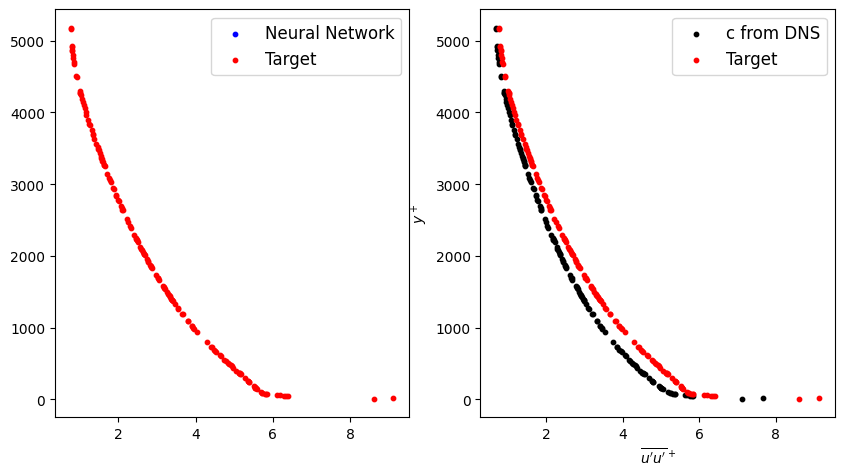

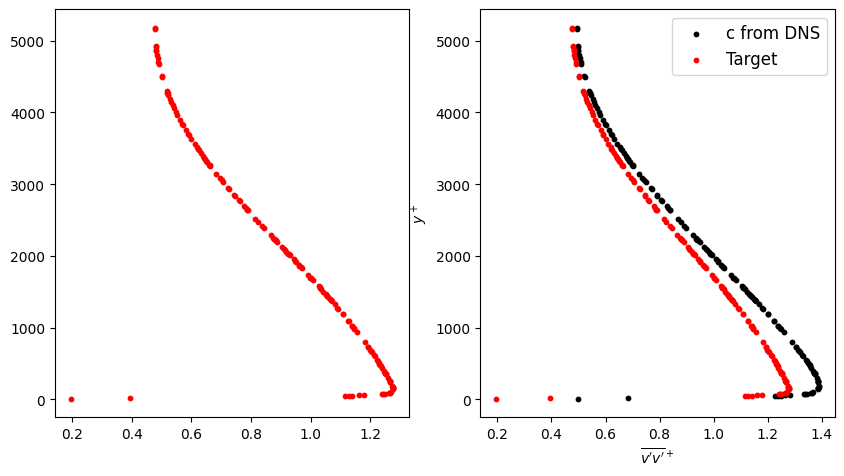

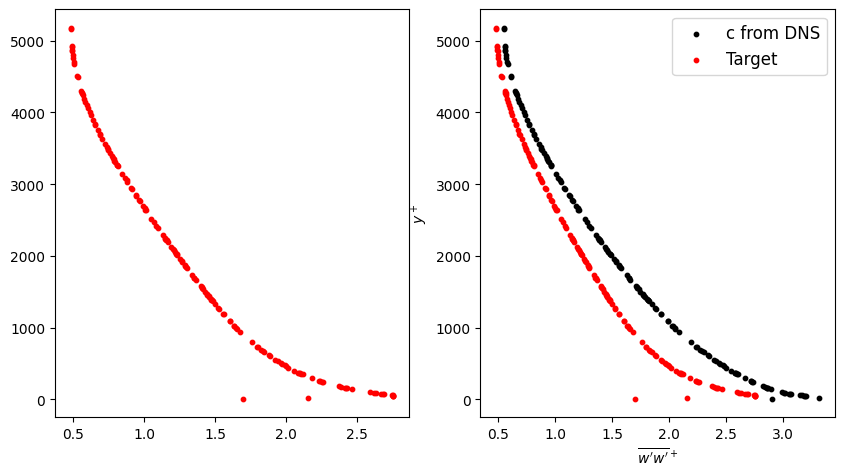

In [11]:
c_NN = preds.detach().numpy()

#tau, dudy, k, uu, vv, ww, yplus, c_0,c_2
ww_NN = ((c_NN[:,0])*(test_var_val[:,0]**2*test_var_val[:,1]**2)/(-6) + 2/3)*test_var_val[:,2]
uu_NN = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((c_NN[:,0]) + 6*(c_NN[:,1])) + 2/3)*test_var_val[:,2]
vv_NN = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((c_NN[:,0]) - 6*(c_NN[:,1])) + 2/3)*test_var_val[:,2]


ww_DNSC = ((test_var_val[:,7])*(test_var_val[:,0]**2*test_var_val[:,1]**2)/(-6) + 2/3)*test_var_val[:,2]
uu_DNSC = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((test_var_val[:,7]) + 6*(test_var_val[:,8])) + 2/3)*test_var_val[:,2]
vv_DNSC = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((test_var_val[:,7]) - 6*(test_var_val[:,8])) + 2/3)*test_var_val[:,2]


fig1, (ax0,ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
plt.subplots_adjust(left=0.25,bottom=0.20)
ax0.scatter(uu_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
ax0.scatter(test_var_val[:,3],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
# ax0.axis([0,9,0,5000])
ax0.legend(loc = "best", fontsize = 12)

ax1.scatter(uu_DNSC,test_var_val[:,6], marker="o", s=10, c="k", label="c from DNS")
ax1.scatter(test_var_val[:,3],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
# plt.axis([0, 9, 0,5000])
plt.xlabel("$\overline{u'u'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

fig2, (ax2,ax3) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
plt.subplots_adjust(left=0.25,bottom=0.20)
ax2.scatter(vv_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
ax2.scatter(test_var_val[:,4],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
# ax2.axis([0, 2, 0,5000])

ax3.scatter(vv_DNSC,test_var_val[:,6], marker="o", s=10, c="k", label="c from DNS")
ax3.scatter(test_var_val[:,4],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
# ax3.axis([0, 2, 0,5000])
plt.xlabel("$\overline{v'v'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

fig3, (ax4,ax5) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
plt.subplots_adjust(left=0.25,bottom=0.20)
ax4.scatter(ww_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
ax4.scatter(test_var_val[:,5],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
# ax4.axis([0, 3, 0,5000])

ax5.scatter(ww_DNSC,test_var_val[:,6], marker="o", s=10, c="k", label="c from DNS")
ax5.scatter(test_var_val[:,5],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
# ax5.axis([0, 3, 0,5000])
plt.xlabel("$\overline{w'w'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)


plt.show()

662519568238870.4
701764221132215.1
662519335200301.0
701764551983661.6


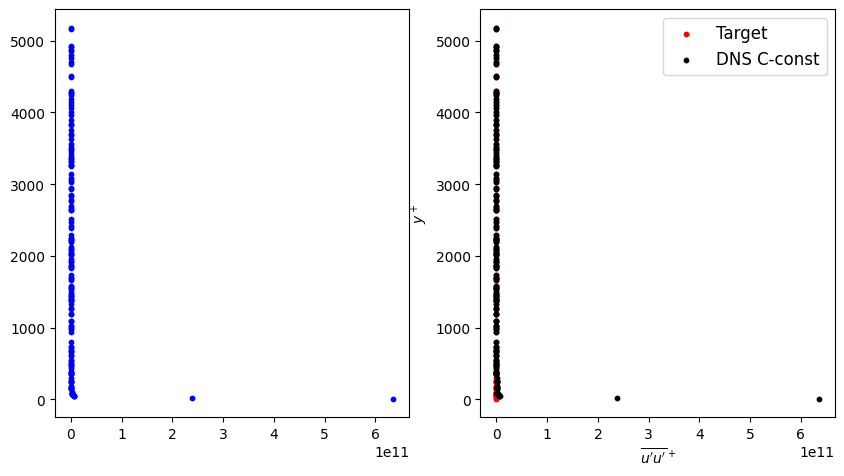

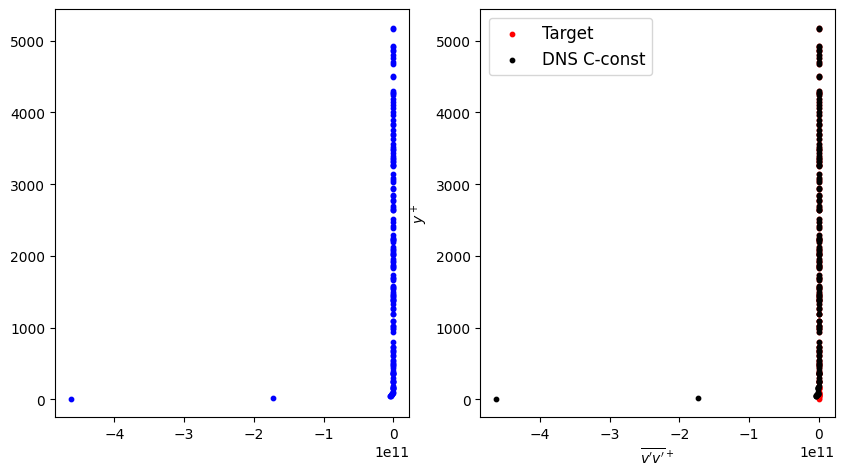

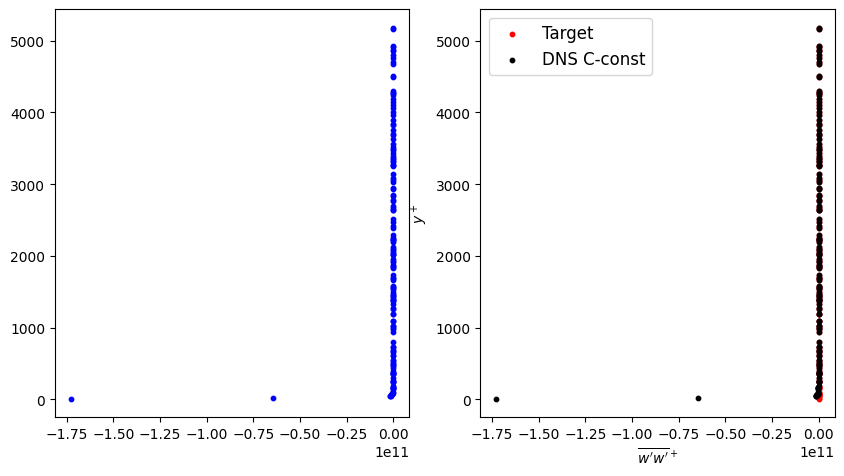

In [12]:
c_NN = y_val_tensor.detach().numpy()

#Not sure how to correctly find mean value, this gives bad results
c_0_NN = np.trapz(c_NN[:,0],test_var_val[:,6])
c_2_NN = np.trapz(c_NN[:,1],test_var_val[:,6])

c_0_DNS = np.trapz(test_var_val[:,7],test_var_val[:,6])
c_2_DNS = np.trapz(test_var_val[:,8],test_var_val[:,6])
print(c_0_NN)
print(c_2_NN)

print(c_0_DNS)
print(c_2_DNS)

#tau, dudy, k, uu, vv, ww, yplus
ww_NN = ((c_0_NN)*(test_var_val[:,0]**2*test_var_val[:,1]**2)/(-6) + 2/3)*test_var_val[:,2]
uu_NN = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((c_0_NN) + 6*(c_2_NN)) + 2/3)*test_var_val[:,2]
vv_NN = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((c_0_NN) - 6*(c_2_NN)) + 2/3)*test_var_val[:,2]

ww_DNS_C = ((c_0_DNS)*(test_var_val[:,0]**2*test_var_val[:,1]**2)/(-6) + 2/3)*test_var_val[:,2]
uu_DNS_C = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((c_0_DNS) + 6*(c_2_DNS)) + 2/3)*test_var_val[:,2]
vv_DNS_C = ((1/12)*test_var_val[:,0]**2*test_var_val[:,1]**2*((c_0_DNS) - 6*(c_2_DNS)) + 2/3)*test_var_val[:,2]


fig1, (ax0,ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
plt.subplots_adjust(left=0.25,bottom=0.20)
ax0.scatter(uu_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
ax1.scatter(test_var_val[:,3],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
ax1.scatter(uu_DNS_C,test_var_val[:,6],marker="o", s=10, c="k", label="DNS C-const")
# ax0.axis([0, 10000, 0,5000])
# ax1.axis([0, 10000, 0,5000])
plt.xlabel("$\overline{u'u'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

fig2, (ax2,ax3) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
plt.subplots_adjust(left=0.25,bottom=0.20)
ax2.scatter(vv_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
ax3.scatter(test_var_val[:,4],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
ax3.scatter(vv_DNS_C,test_var_val[:,6],marker = "o",s = 10, c = "k", label = "DNS C-const")
# ax2.axis([-8000, 0, 0,5000])
# ax3.axis([-8000, 0, 0,5000])
plt.xlabel("$\overline{v'v'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

fig3, (ax4,ax5) = plt.subplots(nrows = 1,ncols =2,figsize = (12,6))
plt.subplots_adjust(left=0.25,bottom=0.20)
ax4.scatter(ww_NN,test_var_val[:,6], marker="o", s=10, c="blue", label="Neural Network")
ax5.scatter(test_var_val[:,5],test_var_val[:,6],marker="o", s=10, c="red", label="Target")
ax5.scatter(ww_DNS_C,test_var_val[:,6],marker="o", s=10, c="k", label="DNS C-const")
# ax4.axis([-2000, 0, 0,5000])
# ax5.axis([-2000, 0, 0,5000])
plt.xlabel("$\overline{w'w'}^+$")
plt.ylabel("$y^+$")
plt.legend(loc="best",fontsize=12)

plt.show()